# MNIST Example: Workflow API

Welcome to the first OpenFL Experimental Workflow Interface tutorial! This notebook introduces the API to get up and running with your first horizontal federated learning workflow. This work has the following goals:

- Simplify the federated workflow representation
- Help users better understand the steps in federated learning (weight extraction, compression, etc.)
- Designed to maintain data privacy
- Aims for syntactic consistency with the Netflix MetaFlow project. Infrastructure reuse where possible.

# What is it?

The workflow interface is a new way of composing federated learning experiments with OpenFL. It was borne through conversations with researchers and existing users who had novel use cases that didn't quite fit the standard horizontal federated learning paradigm. 

# Getting Started

First we start by installing the necessary dependencies for the workflow interface

In [2]:
!fx experimental activate
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

2024-12-18 22:39:26.421661: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-18 22:39:26.423459: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-18 22:39:26.429968: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-18 22:39:26.444879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734541766.471717  258172 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734541766.47

We begin with the quintessential example of a small pytorch CNN model trained on the MNIST dataset. Let's start by defining our data loaders, model, optimizer, and some helper functions like we would for any other deep learning experiment.

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
import numpy as np

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

mnist_train = torchvision.datasets.MNIST(
    "/tmp/files/",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
)

mnist_test = torchvision.datasets.MNIST(
    "/tmp/files/",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

def inference(network,test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in test_loader:
        output = network(data)
        test_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
    accuracy = float(correct / len(test_loader.dataset))
    return accuracy

Next we import the `FLSpec`, `LocalRuntime`, and placement decorators.

- `FLSpec` – Defines the flow specification. User defined flows are subclasses of this.
- `Runtime` – Defines where the flow runs, infrastructure for task transitions (how information gets sent). The `LocalRuntime` runs the flow on a single node.
- `aggregator/collaborator` - placement decorators that define where the task will be assigned

In [4]:
from copy import deepcopy

from openfl.experimental.workflow.interface import FLSpec, Aggregator, Collaborator
from openfl.experimental.workflow.runtime import LocalRuntime
from openfl.experimental.workflow.placement import aggregator, collaborator


def FedAvg(models, weights=None):
    new_model = models[0]
    state_dicts = [model.state_dict() for model in models]
    state_dict = new_model.state_dict()
    for key in models[1].state_dict():
        state_dict[key] = torch.from_numpy(np.average([state[key].numpy() for state in state_dicts],
                                                      axis=0, 
                                                      weights=weights))
    new_model.load_state_dict(state_dict)
    return new_model

Now we come to the flow definition. The OpenFL Workflow Interface adopts the conventions set by Metaflow, that every workflow begins with `start` and concludes with the `end` task. The aggregator begins with an optionally passed in model and optimizer. The aggregator begins the flow with the `start` task, where the list of collaborators is extracted from the runtime (`self.collaborators = self.runtime.collaborators`) and is then used as the list of participants to run the task listed in `self.next`, `aggregated_model_validation`. The model, optimizer, and anything that is not explicitly excluded from the next function will be passed from the `start` function on the aggregator to the `aggregated_model_validation` task on the collaborator. Where the tasks run is determined by the placement decorator that precedes each task definition (`@aggregator` or `@collaborator`). Once each of the collaborators (defined in the runtime) complete the `aggregated_model_validation` task, they pass their current state onto the `train` task, from `train` to `local_model_validation`, and then finally to `join` at the aggregator. It is in `join` that an average is taken of the model weights, and the next round can begin.

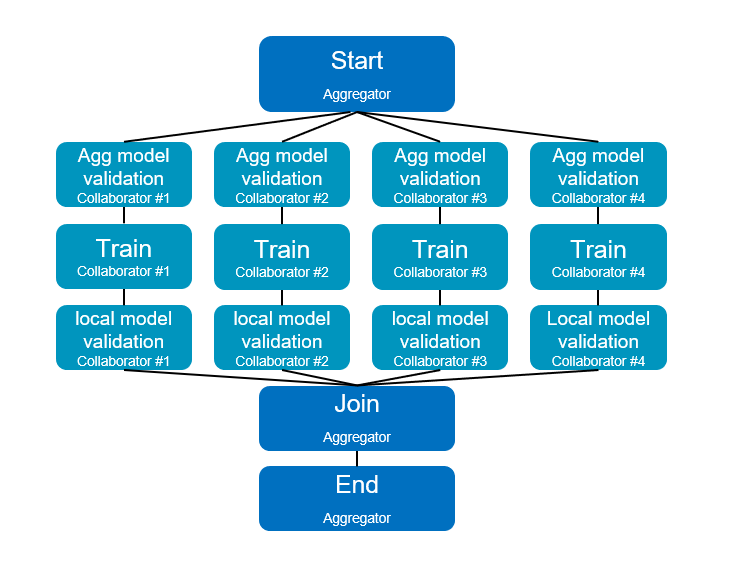

In [5]:
class FederatedFlow(FLSpec):

    def __init__(self, model=None, optimizer=None, rounds=3, **kwargs):
        super().__init__(**kwargs)
        if model is not None:
            self.model = model
            self.optimizer = optimizer
        else:
            self.model = Net()
            self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate,
                                       momentum=momentum)
        self.rounds = rounds

    @aggregator
    def start(self):
        print(f'Performing initialization for model')
        self.collaborators = self.runtime.collaborators
        self.private = 10
        self.current_round = 0
        self.next(self.aggregated_model_validation, foreach='collaborators', exclude=['private'])

    @collaborator
    def aggregated_model_validation(self):
        print(f'Performing aggregated model validation for collaborator {self.input}')
        self.agg_validation_score = inference(self.model, self.test_loader)
        print(f'{self.input} value of {self.agg_validation_score}')
        self.next(self.train)

    @collaborator
    def train(self):
        self.model.train()
        self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate,
                                   momentum=momentum)
        train_losses = []
        for batch_idx, (data, target) in enumerate(self.train_loader):
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            self.optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: 1 [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    batch_idx * len(data), len(self.train_loader.dataset),
                    100. * batch_idx / len(self.train_loader), loss.item()))
                self.loss = loss.item()
                torch.save(self.model.state_dict(), 'model.pth')
                torch.save(self.optimizer.state_dict(), 'optimizer.pth')
        self.training_completed = True
        self.next(self.local_model_validation)

    @collaborator
    def local_model_validation(self):
        self.local_validation_score = inference(self.model, self.test_loader)
        print(
            f'Doing local model validation for collaborator {self.input}: {self.local_validation_score}')
        self.next(self.join, exclude=['training_completed'])

    @aggregator
    def join(self, inputs):
        self.average_loss = sum(input.loss for input in inputs) / len(inputs)
        self.aggregated_model_accuracy = sum(
            input.agg_validation_score for input in inputs) / len(inputs)
        self.local_model_accuracy = sum(
            input.local_validation_score for input in inputs) / len(inputs)
        print(f'Average aggregated model validation values = {self.aggregated_model_accuracy}')
        print(f'Average training loss = {self.average_loss}')
        print(f'Average local model validation values = {self.local_model_accuracy}')
        self.model = FedAvg([input.model for input in inputs])
        self.optimizer = [input.optimizer for input in inputs][0]
        self.current_round += 1
        if self.current_round < self.rounds:
            self.next(self.aggregated_model_validation,
                      foreach='collaborators', exclude=['private'])
        else:
            self.next(self.end)

    @aggregator
    def end(self):
        print(f'This is the end of the flow')

Aggregator step "start" registered
Collaborator step "aggregated_model_validation" registered
Collaborator step "train" registered
Collaborator step "local_model_validation" registered
Aggregator step "join" registered
Aggregator step "end" registered


You'll notice in the `FederatedFlow` definition above that there were certain attributes that the flow was not initialized with, namely the `train_loader` and `test_loader` for each of the collaborators. These are **private_attributes** of the particular participant and (as the name suggests) are accessible ONLY to the particular participant through its task. Additionally these private attributes are always filtered out of the current state when transferring from collaborator to aggregator, and vice versa.
 
Users can directly specify a collaborator's private attributes via `collaborator.private_attributes` which is a dictionary where key is name of the attribute and value is the object that is made accessible to collaborator. In this example, we segment shards of the MNIST dataset for four collaborators: `Portland`, `Seattle`, `Chandler`  and `Bangalore`. Each shard / slice of the dataset is assigned to collaborator's private_attributes.
 
Note that the private attributes are flexible, and user can choose to pass in a completely different type of object to any of the collaborators or aggregator (with an arbitrary name).
 
Subsequent tutorials shall show examples to assign private_attributes for aggregator and another methodology of specifying private attributes via a callable.

In [6]:
# Setup participants
aggregator = Aggregator()
aggregator.private_attributes = {}

# Setup collaborators with private attributes
collaborator_names = ['Portland', 'Seattle', 'Chandler','Bangalore']
collaborators = [Collaborator(name=name) for name in collaborator_names]
for idx, collaborator in enumerate(collaborators):
    local_train = deepcopy(mnist_train)
    local_test = deepcopy(mnist_test)
    local_train.data = mnist_train.data[idx::len(collaborators)]
    local_train.targets = mnist_train.targets[idx::len(collaborators)]
    local_test.data = mnist_test.data[idx::len(collaborators)]
    local_test.targets = mnist_test.targets[idx::len(collaborators)]
    collaborator.private_attributes = {
            'train_loader': torch.utils.data.DataLoader(local_train,batch_size=batch_size_train, shuffle=True),
            'test_loader': torch.utils.data.DataLoader(local_test,batch_size=batch_size_train, shuffle=True)
    }

local_runtime = LocalRuntime(aggregator=aggregator, collaborators=collaborators, backend='single_process')
print(f'Local runtime collaborators = {local_runtime.collaborators}')

Local runtime collaborators = ['Portland', 'Seattle', 'Chandler', 'Bangalore']


Now that we have our flow and runtime defined, let's run the experiment! 

In [7]:
model = None
best_model = None
optimizer = None
flflow = FederatedFlow(model, optimizer, rounds=2, checkpoint=True)
flflow.runtime = local_runtime
flflow.run()

Created flow FederatedFlow

Calling start
Performing initialization for model
Saving data artifacts for start
Saved data artifacts for start

Calling aggregated_model_validation
Performing aggregated model validation for collaborator Portland


/tmp/ipykernel_252106/3655034279.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/karan/playground/openfl/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3264, Accuracy: 309/2500 (12%)

Portland value of 0.12359999865293503
Saving data artifacts for aggregated_model_validation
Saved data artifacts for aggregated_model_validation

Calling train
Train Epoch: 1 [0/15000 (0%)]	Loss: 2.370591
Train Epoch: 1 [640/15000 (4%)]	Loss: 2.265008
Train Epoch: 1 [1280/15000 (9%)]	Loss: 2.300407
Train Epoch: 1 [1920/15000 (13%)]	Loss: 2.249448
Train Epoch: 1 [2560/15000 (17%)]	Loss: 2.251498
Train Epoch: 1 [3200/15000 (21%)]	Loss: 2.267806
Train Epoch: 1 [3840/15000 (26%)]	Loss: 2.201275
Train Epoch: 1 [4480/15000 (30%)]	Loss: 2.181914
Train Epoch: 1 [5120/15000 (34%)]	Loss: 2.115410
Train Epoch: 1 [5760/15000 (38%)]	Loss: 2.086649
Train Epoch: 1 [6400/15000 (43%)]	Loss: 1.970717
Train Epoch: 1 [7040/15000 (47%)]	Loss: 1.829772
Train Epoch: 1 [7680/15000 (51%)]	Loss: 1.933031
Train Epoch: 1 [8320/15000 (55%)]	Loss: 1.816630
Train Epoch: 1 [8960/15000 (60%)]	Loss: 1.799785
Train Epoch: 1 [9600/15000 (64%)]	Loss: 1.677242
Train E

Now that the flow has completed, let's get the final model and accuracy

In [8]:
print(f'Sample of the final model weights: {flflow.model.state_dict()["conv1.weight"][0]}')

print(f'\nFinal aggregated model accuracy for {flflow.rounds} rounds of training: {flflow.aggregated_model_accuracy}')

Sample of the final model weights: tensor([[[ 0.1219, -0.0850, -0.0638,  0.0587, -0.2061],
         [ 0.1559, -0.0204,  0.1003,  0.0273, -0.0150],
         [ 0.1037,  0.0561,  0.1091, -0.0362,  0.0187],
         [ 0.0092,  0.0607,  0.0319,  0.2063,  0.0913],
         [-0.0773, -0.1235, -0.0412, -0.0902, -0.0545]]])

Final aggregated model accuracy for 2 rounds of training: 0.8467999994754791


We can get the final model, and all other aggregator attributes after the flow completes. But what if there's an intermediate model task and its specific output that we want to look at in detail? This is where **checkpointing** and reuse of Metaflow tooling come in handy.

Let's make a tweak to the flow object, and run the experiment one more time (we can even use our previous model / optimizer as a base for the experiment)

In [9]:
flflow2 = FederatedFlow(model=flflow.model, optimizer=flflow.optimizer, rounds=2, checkpoint=True)
flflow2.runtime = local_runtime
flflow2.run()

Created flow FederatedFlow

Calling start
Performing initialization for model
Saving data artifacts for start
Saved data artifacts for start

Calling aggregated_model_validation
Performing aggregated model validation for collaborator Portland


/tmp/ipykernel_252106/3655034279.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.3249, Accuracy: 2275/2500 (91%)

Portland value of 0.9100000262260437
Saving data artifacts for aggregated_model_validation
Saved data artifacts for aggregated_model_validation

Calling train
Train Epoch: 1 [0/15000 (0%)]	Loss: 0.705955
Train Epoch: 1 [640/15000 (4%)]	Loss: 0.617308
Train Epoch: 1 [1280/15000 (9%)]	Loss: 0.623395
Train Epoch: 1 [1920/15000 (13%)]	Loss: 0.713938
Train Epoch: 1 [2560/15000 (17%)]	Loss: 0.714206
Train Epoch: 1 [3200/15000 (21%)]	Loss: 0.563812
Train Epoch: 1 [3840/15000 (26%)]	Loss: 0.717757
Train Epoch: 1 [4480/15000 (30%)]	Loss: 0.394908
Train Epoch: 1 [5120/15000 (34%)]	Loss: 0.826978
Train Epoch: 1 [5760/15000 (38%)]	Loss: 0.462670
Train Epoch: 1 [6400/15000 (43%)]	Loss: 0.698488
Train Epoch: 1 [7040/15000 (47%)]	Loss: 0.846376
Train Epoch: 1 [7680/15000 (51%)]	Loss: 0.619333
Train Epoch: 1 [8320/15000 (55%)]	Loss: 0.575636
Train Epoch: 1 [8960/15000 (60%)]	Loss: 0.622939
Train Epoch: 1 [9600/15000 (64%)]	Loss: 0.886747
Train E

Now that the flow is complete, let's dig into some of the information captured along the way

In [10]:
run_id = flflow2._run_id

In [11]:
from metaflow import Metaflow, Flow, Task, Step

In [12]:
m = Metaflow()
list(m)

[Flow('FederatedFlow')]

For existing users of Metaflow, you'll notice this is the same way you would examine a flow after completion. Let's look at the latest run that generated some results:

In [13]:
f = Flow('FederatedFlow').latest_run

In [14]:
f

Run('FederatedFlow/1734542077639071')

And its list of steps

In [15]:
list(f)

[Step('FederatedFlow/1734542077639071/end'),
 Step('FederatedFlow/1734542077639071/join'),
 Step('FederatedFlow/1734542077639071/local_model_validation'),
 Step('FederatedFlow/1734542077639071/train'),
 Step('FederatedFlow/1734542077639071/aggregated_model_validation'),
 Step('FederatedFlow/1734542077639071/start')]

This matches the list of steps executed in the flow, so far so good...

In [16]:
s = Step(f'FederatedFlow/{run_id}/train')

In [17]:
s

Step('FederatedFlow/1734542077639071/train')

In [18]:
list(s)

[Task('FederatedFlow/1734542077639071/train/25'),
 Task('FederatedFlow/1734542077639071/train/22'),
 Task('FederatedFlow/1734542077639071/train/19'),
 Task('FederatedFlow/1734542077639071/train/16'),
 Task('FederatedFlow/1734542077639071/train/12'),
 Task('FederatedFlow/1734542077639071/train/9'),
 Task('FederatedFlow/1734542077639071/train/6'),
 Task('FederatedFlow/1734542077639071/train/3')]

Now we see **12** steps: **4** collaborators each performed **3** rounds of model training  

In [19]:
t = Task(f'FederatedFlow/{run_id}/train/9')

In [20]:
t

Task('FederatedFlow/1734542077639071/train/9')

Now let's look at the data artifacts this task generated

In [21]:
t.data

<MetaflowData: loss, collaborators, execute_task_args, test_loader, checkpoint, model, training_completed, input, train_loader, rounds, agg_validation_score, optimizer, current_round>

In [22]:
t.data.input

'Chandler'

Now let's look at its log output (stdout)

In [23]:
print(t.stdout)

Train Epoch: 1 [0/15000 (0%)]	Loss: 0.986641
Train Epoch: 1 [640/15000 (4%)]	Loss: 0.487543
Train Epoch: 1 [1280/15000 (9%)]	Loss: 0.999929
Train Epoch: 1 [1920/15000 (13%)]	Loss: 0.838406
Train Epoch: 1 [2560/15000 (17%)]	Loss: 1.006288
Train Epoch: 1 [3200/15000 (21%)]	Loss: 0.875594
Train Epoch: 1 [3840/15000 (26%)]	Loss: 0.684269
Train Epoch: 1 [4480/15000 (30%)]	Loss: 0.751433
Train Epoch: 1 [5120/15000 (34%)]	Loss: 0.948535
Train Epoch: 1 [5760/15000 (38%)]	Loss: 0.701165
Train Epoch: 1 [6400/15000 (43%)]	Loss: 0.605181
Train Epoch: 1 [7040/15000 (47%)]	Loss: 0.572135
Train Epoch: 1 [7680/15000 (51%)]	Loss: 0.584587
Train Epoch: 1 [8320/15000 (55%)]	Loss: 0.677527
Train Epoch: 1 [8960/15000 (60%)]	Loss: 0.775974
Train Epoch: 1 [9600/15000 (64%)]	Loss: 0.579040
Train Epoch: 1 [10240/15000 (68%)]	Loss: 0.779329
Train Epoch: 1 [10880/15000 (72%)]	Loss: 0.705849
Train Epoch: 1 [11520/15000 (77%)]	Loss: 0.367069
Train Epoch: 1 [12160/15000 (81%)]	Loss: 0.578917
Train Epoch: 1 [12800/1

And any error logs? (stderr)

In [24]:
print(t.stderr)

# Congratulations!
Now that you've completed your first workflow interface quickstart notebook, see some of the more advanced things you can do in our [other tutorials](https://github.com/securefederatedai/openfl/tree/develop/openfl-tutorials/experimental/workflow), including:

- Using the LocalRuntime Ray Backend for dedicated GPU access
- Vertical Federated Learning
- Model Watermarking
- Differential Privacy
- And More!